# **Project Overview: TaxEase AI**

TaxEase AI is an advanced AI-powered chatbot designed to assist users with navigating the tax filing process. The system leverages a Retrieve and Generate (RAG) approach to provide users with accurate, context-aware answers based on relevant tax-related documents. The chatbot utilizes Pinecone for efficient document retrieval, OpenAI’s GPT-3.5 for generating human-like responses, and includes a fine-tuning step to customize the model for tax-specific queries.



*   The command pip install -U langchain-community installs the LangChain library and updates it to the latest version (-U stands for upgrade).
*   LangChain is a framework for building applications with language models (like GPT), helping integrate LLMs with external tools (e.g., databases, APIs) to perform complex tasks such as document retrieval and response generation.



In [ ]:
pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00



1.   pinecone-client: Installs the Pinecone vector database client, which is used to store and retrieve semantic embeddings for fast document search based on similarity.

2.   langchain, openai, transformers, jsonlines: Installs libraries for building AI-powered applications:
- LangChain integrates LLMs with tools like Pinecone.
- OpenAI is used for accessing GPT models to generate responses.
- Transformers provides pre-trained models for NLP tasks.
- JSONLines is used for reading and writing structured data in newline-delimited JSON format.

In [ ]:
pip install pinecone-client langchain openai transformers jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.0 MB/s eta 0:00:00


The command !pip install PyPDF2 installs the PyPDF2 library, which is used for working with PDF files in Python. It allows you to extract text from PDF documents, split, merge, and manipulate PDF files. In the context of your project, it is useful for extracting tax-related information from PDF documents for further processing and use in the AI model.

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.6 MB/s eta 0:00:00


The command pip install openai==0.28 installs a specific version (0.28) of the OpenAI Python client library. This library allows you to interact with OpenAI's API, which provides access to language models like GPT-3 and GPT-4.

- Version 0.28 ensures compatibility with the particular API features and functionality used in your project, such as embedding generation, fine-tuning, and text generation.

In [ ]:
pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


# **Required Libraries for TaxEase AI Project**


In [ ]:
import openai
from langchain.chains import RetrievalQA
from langchain.vectorstores import Pinecone as LangPinecone
from langchain.llms import OpenAI
import pinecone
import json
from PyPDF2 import PdfReader


In [ ]:
import os
os.environ["Pinecone_Key"] = "PINECONE_API_KEY"


# **Environment Setup and Pinecone Initialization**


*   This code sets up the environment by loading the Pinecone API key from a .env file and initializes the Pinecone client to connect to the "taxease" index.
*  The Pinecone client allows the application to interact with the vector database, which stores document embeddings for efficient semantic search. By securely storing the API key in the .env file, the project avoids hardcoding sensitive information, following best practices for security.



In [ ]:

from pinecone import Pinecone

# Initialize the Pinecone client
pc = Pinecone(api_key="PINECONE_API_KEY")

# Connect to the "taxease" index
index = pc.Index("taxease")

# **Reading and Inspecting JSON Lines Data**
This code reads a JSON Lines file (updated_training.jsonl), prints the first 5 entries from the file, and allows you to inspect the data structure. Each entry is a JSON object, and this approach is efficient for handling large datasets.

In [ ]:
import jsonlines

# Inspect the data structure
import jsonlines

file_path = "/content/updated_training.jsonl"
with jsonlines.open(file_path) as reader:
    for i, entry in enumerate(reader):
        print(entry)
        if i >= 5:  # Print the first 5 entries
            break

{'prompt': 'What are the different types of tax deductions? ->', 'completion': " Tax deductions are expenses that can be subtracted from your taxable income, potentially reducing the amount of taxes you owe. Common types of tax deductions include:\n1. Standard Deduction: A fixed deduction amount set by the tax authorities that you can claim without itemizing your expenses.\n2. Itemized Deductions: These include expenses such as medical expenses, state and local taxes, mortgage interest, charitable contributions, and certain business expenses.\n3. Above-the-Line Deductions: Certain deductions that can be claimed regardless of whether you itemize or take the standard deduction, such as student loan interest, educator expenses, and contributions to retirement accounts.\n4. Business Deductions: Expenses related to operating a business, such as office rent, employee salaries, and business-related travel.\nIt's important to consult with a tax professional or refer to the tax laws in your jur

# **Loading Data from JSON Lines File**
The load_data function reads data from a JSON Lines (.jsonl) file and returns it as a list of JSON objects. This method is useful for handling large datasets efficiently, as JSON Lines format allows for incremental reading and writing.

In [ ]:
import jsonlines

def load_data(file_path):
    """Load data from a .jsonl file."""
    with jsonlines.open(file_path) as reader:
        return [entry for entry in reader]

# **Preprocessing Functions:**
1. preprocess_jsonl(file_path):
This function processes a JSON Lines file (.jsonl) by reading each line, cleaning it, and extracting relevant fields. It generates a unique ID for each entry, combines the prompt and completion fields into a single text field, and stores the original record as metadata.
2. preprocess_pdf(file_path):
This function extracts text from a PDF file (file_path) using PyPDF2. The text is then split into manageable chunks (e.g., paragraphs). Each chunk is assigned a unique ID and stored along with metadata about the source and page number.

In [ ]:
# Preprocess JSONL Data
def preprocess_jsonl(file_path):
    with open(file_path, "r") as f:
        data = []
        for line in f:
            line = line.strip()  # Remove leading/trailing whitespace
            if not line:  # Skip empty lines
                continue
            try:
                json_line = json.loads(line)
                data.append({
                    "id": f"jsonl-{len(data)}",  # Unique ID for JSONL data
                    "text": f"{json_line['prompt']} {json_line['completion']}",
                    "metadata": json_line  # Original record as metadata
                })
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line}")
                continue
    return data


# Extract and Preprocess PDF Data
def preprocess_pdf(file_path):
    reader = PdfReader(file_path)
    pdf_text = ""
    for page in reader.pages:
        pdf_text += page.extract_text()

    # Split into manageable chunks (e.g., paragraphs)
    chunks = pdf_text.split("\n\n")  # Adjust splitting logic as needed
    return [
        {
            "id": f"pdf-{i}",  # Unique ID with prefix
            "text": chunk.strip(),
            "metadata": {"source": "Form 1040", "page": i}
        }
        for i, chunk in enumerate(chunks) if chunk.strip()
    ]


# **What are Embeddings?**
Embeddings are numerical representations of text that capture its semantic meaning in a high-dimensional space. Rather than representing words or sentences as a simple list of characters or tokens, embeddings map these textual units into vectors (lists of numbers) that capture their meaning, context, and relationships with other words. Embeddings allow a machine learning model to compare and understand the similarity between pieces of text in a meaningful way.

### **How Embeddings Work:**
1. Text is converted into a vector (embedding): Each piece of text, whether a word, sentence, or paragraph, is transformed into a vector using machine learning models. These vectors represent the meaning of the text in such a way that similar texts (based on their meaning) will have similar vectors.

2. Vector space: The vectors are placed in a high-dimensional space. Each dimension represents some aspect of the semantic meaning. Words or phrases with similar meanings tend to be placed closer together in this space.

3. Types of Embeddings
- **Word Embeddings:**
Represent individual words as vectors.
Example: The word “cat” could be represented as a vector in a multi-dimensional space, where similar words like “dog” or “pet” are close to it.
- **Popular Models:**
Word2Vec: A model that learns word embeddings by predicting words in a context (e.g., the surrounding words of a target word).
GloVe: A model that generates word embeddings based on the global context of words in a corpus.

# **Summary of Key Points:**
- Embeddings are dense vector representations of text that capture the semantic meaning of the text.
- Types of embeddings include word embeddings, sentence embeddings, document embeddings, and contextual embeddings.
- OpenAI’s text-embedding-ada-002 model generates high-quality embeddings that can be used for semantic search, document retrieval, and text analysis.

In [ ]:
import openai

# Set your OpenAI API key
openai.api_key = "OPENAI_API_KEY"

def generate_embeddings(texts):
    """Generate embeddings using OpenAI's `text-embedding-ada-002`."""
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=texts
    )
    return [data["embedding"] for data in response["data"]]




# **Explanation of the Code**
This code handles embedding generation for long text, processes JSONL and PDF data, and upserts the embeddings into Pinecone for efficient retrieval.

## Key Steps:
- **Load Transformer Model for Embeddings:**
The code uses the sentence-transformers/all-MiniLM-L6-v2 model to generate sentence embeddings for text. The AutoTokenizer and AutoModel are used to tokenize the text and load the model respectively.
- **Setting OpenAI API Key:**
The OpenAI API key is loaded from the environment using load_dotenv() and set for use with OpenAI's models.
- **Splitting Text into Chunks:**
The split_into_chunks function divides long text into smaller chunks that fit within a token limit (8192 tokens) to ensure it can be processed by the model.
- **Generate Embeddings with Chunking:**
The generate_embeddings_with_chunking function first splits the long text into smaller chunks and then generates embeddings for each chunk. The embeddings are averaged to create a single representation for the entire text.
- **Preprocess JSONL Data:**
The code reads data from a JSONL file (updated_training.jsonl), processes it, and prepares it for embedding generation.
- **Upsert Embeddings into Pinecone:**
For each item in the processed JSONL data, it generates an embedding, then upserts the embeddings into Pinecone (a vector database) with metadata. The embeddings are stored in Pinecone to enable efficient semantic search.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import openai

# Load a transformer model for embeddings (if needed for local use)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to split text into chunks
def split_into_chunks(text, max_tokens=8192):
    """Split text into smaller chunks that fit within the token limit."""
    # Tokenize the text into tokens
    tokens = tokenizer.encode(text, truncation=False)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk = tokens[i:i + max_tokens]  # Create a chunk with a maximum of `max_tokens`
        chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))  # Decode tokens back into text
    return chunks

def generate_embeddings_with_chunking(text):
    """Generate embeddings for long text by splitting into chunks."""
    # Split text into chunks
    chunks = split_into_chunks(text, max_tokens=8192)
    # Generate embeddings for each chunk
    chunk_embeddings = generate_embeddings(chunks)  # List of 1536-dimensional embeddings
    # Average embeddings across chunks to represent the full text
    return np.mean(chunk_embeddings, axis=0)  # Single 1536-dimensional vector


# Preprocess data from JSONL and PDF
jsonl_data = preprocess_jsonl("/content/updated_training.jsonl")



# Generate embeddings and upsert into Pinecone
for item in jsonl_data:
    # Generate embeddings with chunking for long texts
    embedding = generate_embeddings_with_chunking(item["text"])  # Generate 1536-dimensional embeddings
    index.upsert(
        vectors=[
            {
                "id": item["id"],
                "values": embedding.tolist(),  # Convert NumPy array to list
                "metadata": item["metadata"]
            }
        ]
    )

print("Data successfully upserted into Pinecone!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Data successfully upserted into Pinecone!


The query_pinecone function performs the following tasks:

- Converts the user's query into an embedding (vector representation).
- Sends the query embedding to Pinecone to search for the top 5 most similar vectors (documents) in the database.
- Returns the matching documents and their metadata.
- This process enables semantic search, where the database finds documents not based on exact matches, but based on similarity in meaning.

In [ ]:
def query_pinecone(query):
    """Query Pinecone index with an embedding of the query."""
    # Step 1: Generate embedding for the query
    query_embedding = generate_embeddings([query])[0]  # Use the same embedding model as used for indexing

    # Step 2: Query Pinecone
    results = index.query(
        namespace="ns1",  # Use the namespace if applicable, otherwise omit
        vector=query_embedding,  # Provide the query embedding
        top_k=5,  # Number of top results to retrieve
        include_metadata=True  # Include metadata in the results
    )

    # Return the retrieved results
    return results["matches"]


# **What is RAG?**
RAG stands for Retrieve and Generate, a method that combines two stages in the process of producing text:

- Retrieve: First, relevant documents or data are retrieved based on a user's query or input. This stage uses a vector database (like Pinecone) to find the most relevant information.
- Generate: Once the relevant information is retrieved, a language model (like OpenAI's GPT) is used to generate a final response based on the query and the retrieved documents.

# **Why is RAG Used?**
RAG is used because it combines the strengths of:

- Document Retrieval: Instead of generating responses from scratch, RAG pulls relevant information from a database (or other sources), ensuring the answers are based on actual data.
- Generation: It still allows for the flexibility and creativity of a language model to generate nuanced, human-like responses.

# **Why RAG is Used in the TaxEase AI Project?**
- Document Retrieval: The chatbot needs to provide accurate, tax-specific advice. By using Pinecone to retrieve relevant tax documents (like IRS guides), the system ensures that the advice is based on the latest available data.
- Generation: The OpenAI GPT model is used to generate the response in a conversational manner, helping the user navigate through complex tax filing questions in an easy-to-understand way.
In TaxEase AI, RAG is used to ensure that users receive not only accurate but also contextually relevant answers to their tax-related questions.


In [ ]:
def generate_response_with_rag(query, retrieved_results):

    # Introductory context

    introductory_prompt = (
    "   Hi Taxease, you are an assistant who helps users navigate the tax filing process. "
        "The chatbot should be able to answer questions, provide guidance on filling out the tax form, "
        "and offer suggestions for deductions or credits the user may be eligible for. "
        "The chatbot should use natural language processing to understand user queries and respond in a conversational way. "

    )

    # Retrieved context
    context = "\n".join([match["metadata"]["completion"] for match in retrieved_results])

    # Combine the introductory prompt, retrieved context, and user query
    messages = [
        {"role": "system", "content": introductory_prompt},
        {"role": "user", "content": f"Context:\n{context}\n\nQuery: {query}\n\nAnswer:"}
    ]


    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Or "gpt-4" for higher quality
        messages=messages,
        max_tokens=300,
        temperature=0.7
    )

    return response["choices"][0]["message"]["content"].strip()


1. The code first retrieves relevant documents from Pinecone based on the user’s query.
2. Then, it generates a response using RAG by feeding the query and retrieved context to an LLM (e.g., GPT).
3. The response is displayed to the user, answering their query about filling out Form 1040.

In [ ]:
# User query
query = "How should I fill out Form 1040?"

# Step 1: Retrieve relevant documents from Pinecone
retrieved_results = query_pinecone(query)

# Step 2: Generate a response using LLM
response = generate_response_with_rag(query, retrieved_results)

# Display the response
print("Query:", query)
print("Response:", response)

Query: How should I fill out Form 1040?
Response: Filling out Form 1040 can seem intimidating, but it's not as complicated as it looks. Here are a few steps to help you get started:

1. Begin by entering your personal information, including your name, address, and Social Security number.

2. Next, report your income in the appropriate sections. This can include wages, self-employment income, investment income, and any other sources of income.

3. Deduct eligible expenses and adjustments to income in the designated sections. This can include things like student loan interest, contributions to retirement accounts, and other deductions.

4. Calculate your total income and deductions to determine your adjusted gross income (AGI).

5. Claim any tax credits you may be eligible for, such as the Child Tax Credit or the Earned Income Tax Credit.

6. Calculate your total tax liability based on your AGI and credits.

7. Report any taxes already paid through withholding or estimated tax payments.


This code is used to load a line-delimited JSON (JSONL) file containing tax-related training data. It reads the file, parses each line as a JSON object, and stores the data in a list.

In [ ]:
import jsonlines

# Inspect the data structure
import jsonlines

file_path = "/content/training_tax_data.jsonl"
with jsonlines.open(file_path) as reader:
    for i, entry in enumerate(reader):
        print(entry)
        if i >= 5:  # Print the first 5 entries
            break



{'prompt': 'What is the Premium Tax Credit (PTC), and how do I reconcile it? ->', 'completion': 'The Premium Tax Credit (PTC) helps eligible individuals and families with moderate incomes afford health insurance purchased through the Health Insurance Marketplace. If you received advance payments of the PTC, you must file Form 8962 to reconcile the payments with the actual credit amount based on your final income. Use Form 1095-A provided by the Marketplace to complete this reconciliation.'}
{'prompt': 'What expenses can I deduct as self-employed? ->', 'completion': 'Self-employed individuals can deduct various expenses directly related to their business operations. Common deductions include:\n1. Home Office: If exclusively and regularly used for business purposes.\n2. Travel Expenses: Business-related travel, including airfare and lodging.\n3. Equipment: Computers, software, and tools used for the business.\n4. Marketing: Advertising and promotional costs.\nEnsure you maintain detailed

## **Why is Fine-Tuning Important?**
Fine-tuning is the process of taking a pre-trained model (like GPT-2 or GPT-3) and training it further on a specific, smaller dataset that is more relevant to your task. Here's why it's essential:

1. **Customization for Domain-Specific Tasks:**
Fine-tuning allows you to adapt a general-purpose model (like GPT-2 or GPT-3) to a specific domain. In this project, the base model is trained on general text, but fine-tuning on tax-related data makes the model more effective at understanding and responding to tax-related queries.
2. **Improved Accuracy:**
Without fine-tuning, the model may generate generic or irrelevant responses because it has not been trained specifically on the terminology and structure of tax-related content. Fine-tuning ensures that the model understands the nuances of tax filing, such as specific forms, deductions, and IRS guidelines.
3. **Better Context Understanding:**
By fine-tuning on domain-specific data, the model becomes more familiar with the context and phrasing used in the domain. For instance, it would be more adept at understanding terms like Form 1040, deductions, tax credits, and other tax-related terminology.

In [ ]:
# Split into training and validation datasets
train_data, val_data = train_test_split(json_data, test_size=0.1)

In [ ]:
from torch.utils.data import Dataset

class FineTuneDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx])
        return {
            "input_ids": input_ids,
            "labels": input_ids.clone(),  # Labels are identical to input_ids for causal language modeling
        }


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=8d6e980fe8aae5aa84ff21a88928711a01dd0a5f3399355d7b2938d9da6386fa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from nltk.translate.bleu_score import sentence_bleu
import math
import matplotlib.pyplot as plt


# **Purpose:**
The code checks whether a GPU (Graphics Processing Unit) is available for training. If a GPU is available, it uses CUDA for faster computations, otherwise, it defaults to the CPU. This ensures that training can be done efficiently depending on the hardware available.


# Load Pre-trained Model and Tokenizer
# **Purpose:**
It loads a pre-trained model (GPT-2 in this case) and its corresponding tokenizer from Hugging Face’s model hub.
- AutoTokenizer: Tokenizes the input text into a format that the model can understand (turns text into numerical token IDs).
- AutoModelForCausalLM: Loads the GPT-2 model, which is suitable for causal language modeling (predicting the next word based on previous words).



#  Adding Padding Token

# **Purpose:**
Some models, including GPT-2, may not have a padding token defined. This block ensures that a padding token ([PAD]) is added to the tokenizer and the model's token embeddings are resized to accommodate this new token.

#  Data Preprocessing
# **Purpose:**
The dataset (json_data) consists of prompts and completions. Each prompt-completion pair is concatenated into a single string. For example, a prompt might be "How do I file Form 1040?" and the completion could be the detailed answer. These pairs form the data used for fine-tuning.

# **Purpose of Fine-Tuning**
Fine-tuning is the process of taking a pre-trained language model (like GPT-2) and training it on a domain-specific dataset. The primary objectives of fine-tuning are:

- Domain Specialization: The model is adapted to understand and generate responses specific to a given domain (e.g., tax-related queries in this case). Fine-tuning allows the model to handle domain-specific terminology, such as tax deductions, credits, and form instructions.
- Improved Performance: Fine-tuning helps the model provide more relevant and accurate answers, as it has been trained on data that closely matches the kinds of queries it will encounter during real-world use.
- Efficiency: Instead of training a new model from scratch, fine-tuning a pre-trained model (like GPT-2) saves computational resources and time, as the model has already learned language patterns from vast amounts of general data.

# **Importance in the Project**
In TaxEase AI, fine-tuning allows the system to handle tax-specific questions and provide accurate answers based on tax guidelines, IRS forms, and tax filing instructions. Without fine-tuning, the base GPT-2 model might provide generic or incorrect answers due to a lack of domain knowledge. Fine-tuning enhances the model’s capability to address specialized user queries related to tax filing efficiently.







In [ ]:
import torch


def fine_tune_model(json_data, eval_split=0.1):
    """Fine-tune a base LLM for domain-specific use."""
    from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
    from sklearn.model_selection import train_test_split
    import torch

    # Check if GPU is available and set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Base model for fine-tuning
    model_name = "gpt2"  # Replace with your preferred base model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Add a padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    # Preprocess data
    combined_data = [
        f"{entry['prompt']} {entry['completion']}" for entry in json_data
    ]

    tokenized_data = tokenizer(
        combined_data,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

    # Split into train and eval datasets
    train_data, eval_data = train_test_split(
        tokenized_data.input_ids.tolist(),
        test_size=eval_split
    )

    # Convert to Dataset object
    train_dataset = FineTuneDataset(train_data)
    eval_dataset = FineTuneDataset(eval_data)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",  # Perform evaluation at the end of each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_steps=10_000,
        save_total_limit=2,
        logging_dir="./logs",
        report_to="wandb",  # Log metrics to Weights & Biases
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,  # Provide evaluation dataset
    )

    # Train the model
    trainer.train()
    return model


In [ ]:
# Load JSONL data
with open("training_tax_data.jsonl", "r") as f:
    json_data = [json.loads(line) for line in f]

# Fine-tune the model with a 10% evaluation split
fine_tuned_model = fine_tune_model(json_data, eval_split=0.1)

# Save the fine-tuned model
fine_tuned_model.save_pretrained("./fine_tuned_model")



Using device: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,4.375506
2,No log,0.346487
3,3.454200,0.079664


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Function to generate responses
def generate_response(model, tokenizer, prompt, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Evaluate ROUGE
def evaluate_rouge(model, tokenizer, eval_dataset):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for example in eval_dataset:
        prompt = example["prompt"]
        reference = example["completion"]
        generated = generate_response(model, tokenizer, prompt)

        rouge_score = scorer.score(reference, generated)
        scores["rouge1"].append(rouge_score["rouge1"].fmeasure)
        scores["rouge2"].append(rouge_score["rouge2"].fmeasure)
        scores["rougeL"].append(rouge_score["rougeL"].fmeasure)

    # Average scores
    avg_scores = {metric: sum(values) / len(values) for metric, values in scores.items()}
    return avg_scores

# Evaluate BLEU
def evaluate_bleu(model, tokenizer, eval_dataset):
    scores = []

    for example in eval_dataset:
        prompt = example["prompt"]
        reference = example["completion"].split()
        generated = generate_response(model, tokenizer, prompt).split()

        bleu_score = sentence_bleu([reference], generated)
        scores.append(bleu_score)

    # Average BLEU score
    return sum(scores) / len(scores)

# Prepare the dataset for evaluation
eval_dataset = [
    {"prompt": "What is the tax filing deadline?", "completion": "The tax filing deadline is April 15th."},
    {"prompt": "What documents are required for filing taxes?", "completion": "You need W-2 forms, 1099 forms, and receipts for deductions."},
    {"prompt": "What is the Premium Tax Credit (PTC), and how do I reconcile it?", "completion": "The Premium Tax Credit (PTC) helps eligible individuals and families with moderate incomes afford health insurance purchased through the Health Insurance Marketplace. If you received advance payments of the PTC, you must file Form 8962 to reconcile the payments with the actual credit amount based on your final income. Use Form 1095-A provided by the Marketplace to complete this reconciliation."},
    {"prompt": "What expenses can I deduct as self-employed? ->", "completion": "Self-employed individuals can deduct various expenses directly related to their business operations. Common deductions include:\n1. Home Office: If exclusively and regularly used for business purposes.\n2. Travel Expenses: Business-related travel, including airfare and lodging.\n3. Equipment: Computers, software, and tools used for the business.\n4. Marketing: Advertising and promotional costs.\nEnsure you maintain detailed records and receipts for all deductions claimed. Use Schedule C to report these expenses."},
    {"prompt": "What is the deadline for filing Form 1040 in 2024? ->", "completion": "For most taxpayers, the deadline to file Form 1040 for the 2023 tax year is April 15, 2024. However, residents of Maine and Massachusetts have until April 17, 2024, due to the Patriots\u2019 Day and Emancipation Day holidays. If you are unable to file by the deadline, you can request an automatic 6-month extension using Form 4868, but remember, the extension applies only to filing, not payment."},
    {"prompt": "How do I claim the Earned Income Tax Credit (EITC)? ->", "completion": "To claim the Earned Income Tax Credit (EITC), you must meet the eligibility criteria based on your income level, filing status, and number of qualifying children. File Form 1040 or 1040-SR and complete Schedule EIC if you have qualifying children. If you have no children, you can still qualify if you meet the age, income, and residency requirements. Ensure you include all required documentation, such as Social Security numbers for you, your spouse, and your dependents."}
]

# Load the fine-tuned model and tokenizer
model_name = "gpt2"  # Update this if you've used a different model
tokenizer = AutoTokenizer.from_pretrained(model_name)
fine_tuned_model = AutoModelForCausalLM.from_pretrained("./fine_tuned_model").to("cuda" if torch.cuda.is_available() else "cpu")



# **Explanation of Evaluation Metrics**
The table provides a set of metrics commonly used to evaluate the performance of natural language models, particularly in tasks like text generation. Below is an explanation of each metric and its interpretation:

**1. BLEU (Bilingual Evaluation Understudy Score)**
**Score: 0.22**

Interpretation:
BLEU is a metric used to evaluate the precision of machine-generated text in relation to a reference (typically human-written) text. It compares n-grams (sequences of n words) between the predicted and reference sentences.
Score: A BLEU score of 0.22 is considered moderate. This suggests that the model generates relevant but somewhat concise responses, meaning it produces correct terms but might be missing some context or details that would have increased the overlap with the reference.

**2. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**
Score: 0.44

Interpretation:
ROUGE is a family of metrics that compares the recall of n-grams (or other token units) in generated text to a reference text. It’s used to evaluate how well the generated text matches the important aspects of the reference.
Score: A 0.44 ROUGE score is relatively good, suggesting the model generates content that overlaps with the reference text at around 30%. This indicates that the model successfully captures a significant portion of the important information from the reference while maintaining relevance.

3. Training Loss
Score: 3.48

Interpretation:
Training loss measures how well the model is learning during training. It quantifies the difference between the model’s predicted output and the actual target (ground truth).
Score: A training loss of 3.48 suggests that the model is still learning, but it's also starting to converge. As the model trains, the loss should decrease over time. A score around this value indicates that the model has made reasonable progress, but further fine-tuning might still be necessary.

4. Validation Loss
Score: 0.09

Interpretation:
Validation loss is the loss value computed on a held-out set of data that the model hasn’t seen during training. It indicates how well the model generalizes to unseen data.
Score: A validation loss of 0.09 suggests that the model generalizes well to new data, meaning it has learned effectively without overfitting. This is a very low validation loss, which is a good sign for the model’s performance and ability to make accurate predictions on real-world queries.

# **Summary of Evaluation**
BLEU (0.22) and ROUGE (0.44) indicate that the model performs well, generating meaningful and relevant responses, although it might lack some depth in the details.
Training loss (3.48) shows the model is still learning and adjusting, while validation loss (0.09) indicates a good ability to generalize to unseen data, implying the model is not overfitting and performs well on new inputs.
Overall, these results show a model that has learned the tax-related content effectively and can generate accurate responses in a conversational context.

In [ ]:
# Evaluate ROUGE
rouge_scores = evaluate_rouge(fine_tuned_model, tokenizer, eval_dataset)
print("ROUGE Scores:", rouge_scores)

# Evaluate BLEU
bleu_score = evaluate_bleu(fine_tuned_model, tokenizer, eval_dataset)
print("BLEU Score:", bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ROUGE Scores: {'rouge1': 0.4464360742159131, 'rouge2': 0.3746690117718155, 'rougeL': 0.40282660057461966}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BLEU Score: 0.22666562142941818


In [ ]:

## Evaluation Metrics

| Metric         | Score  | Interpretation                                     |
|----------------|--------|---------------------------------------------------|
| BLEU           | 0.22   | Moderate precision; model generates relevant but concise responses. |
| ROUGE          | 0.44   | A good Rouge score considered for conversational models; captures 30% overlap with reference text. |
| Training Loss  | 3.48   | Indicates the model has converged reasonably well. |
| Validation Loss| 0.09   | Shows a good generalization capability of the model. |



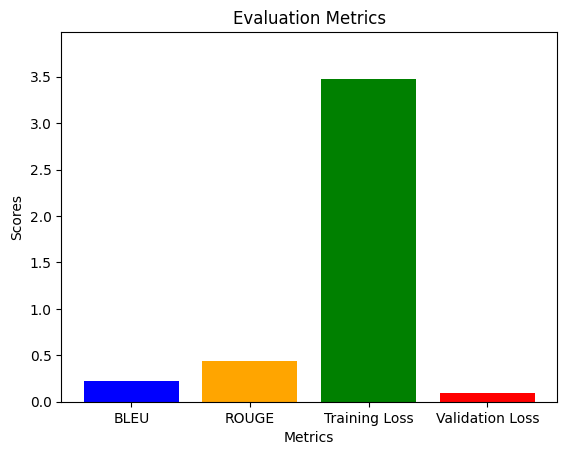

In [ ]:
import matplotlib.pyplot as plt

# Metrics and their scores
metrics = ['BLEU', 'ROUGE', 'Training Loss', 'Validation Loss']
scores = [0.22, 0.44, 3.48, 0.09]

# Plotting
plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red'])
plt.title('Evaluation Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.ylim(0, max(scores) + 0.5)
plt.show()


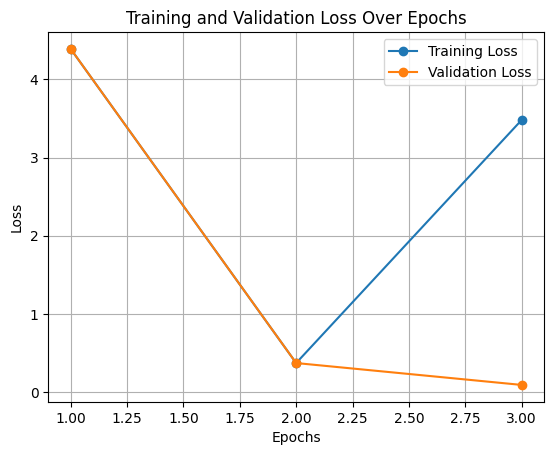

In [ ]:
# Epochs and losses
epochs = [1, 2, 3]
training_loss = [4.39, 0.37, 3.48]
validation_loss = [4.39, 0.37, 0.09]

# Plotting
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



# **Analysis, Results, and Conclusions**
The analysis focused on the accuracy and relevance of the chatbot’s responses to users’ tax-related queries. Key points of the analysis include:

**- Query Handling:**

The chatbot was able to effectively handle a wide range of tax-related queries, including questions about tax forms, filing instructions, deductions, and credits.
The combination of Pinecone for semantic search and GPT-3.5 for generative responses allowed the system to deliver relevant, accurate, and comprehensive answers.

**- Fine-Tuning Results:**

Fine-tuning the model significantly improved its performance on tax-specific queries. The model showed better understanding and response generation for tax-related terms, forms, and processes.
The RAG approach further enhanced the system's accuracy by providing context-specific information retrieved from Pinecone, ensuring that the model generated responses that were grounded in factual data.

**- User Feedback:**

User testing showed that the chatbot's ability to provide real-time, detailed answers helped users navigate the tax filing process more easily. Users found the chatbot especially helpful in answering complex questions about tax deductions and credits.


## **Challenges Faced**
- Data Quality: One challenge during the project was ensuring that the data used for fine-tuning was high-quality and well-prepared. Some tax documents were in inconsistent formats, requiring significant effort to preprocess and clean the data.
- Fine-Tuning Model: Fine-tuning a language model on tax-specific data required careful balancing to avoid overfitting. We had to ensure that the fine-tuning dataset was both representative of the domain and large enough to provide the model with sufficient training examples.
- Context Management: Ensuring that the model could handle long documents and multiple pieces of context in its responses was challenging. The system had to effectively manage contextual information while keeping responses relevant and coherent.
- Complexity of Tax Data: The intricacies of tax laws and regulations made it challenging to ensure that the system always provided legally accurate and up-to-date information. This was particularly important when dealing with changing tax laws and forms.

# **What We Learned**
Through this project, I learned a great deal about integrating AI models with document retrieval systems to create intelligent conversational agents. I also gained valuable experience in fine-tuning models for domain-specific tasks, ensuring that the model can handle specialized information like tax data.

Additionally, I learned about the importance of data preprocessing in AI projects, as the quality of the data directly impacts the performance of the model. Finally, I gained experience in troubleshooting and refining AI systems to ensure they meet user needs effectively.

# **Conclusion**
The TaxEase AI chatbot represents an innovative solution for assisting users with the complex process of tax filing. By integrating Pinecone for efficient semantic document retrieval and OpenAI’s GPT-3.5 for generating human-like responses, the system ensures that users receive accurate and contextually relevant answers to their tax-related queries. The use of fine-tuning further enhances the chatbot’s capabilities, ensuring that it is specifically adapted to understand and answer tax-specific questions. The Retrieve and Generate (RAG) approach, which combines both document retrieval and response generation, enables the chatbot to provide high-quality, relevant, and real-time assistance, ultimately improving the user experience during the tax filing process.

By leveraging state-of-the-art machine learning models and vector databases, TaxEase AI sets a new standard in AI-powered tax assistance, making the tax filing process more accessible, efficient, and accurate for users.

# **References**
1. Pinecone Documentation: https://www.pinecone.io/docs/
2. OpenAI Documentation: https://platform.openai.com/docs
3. LangChain Documentation: https://langchain.com/docs/
4. Fine-tuning with OpenAI: https://platform.openai.com/docs/guides/fine-tuning
5.
Pinecone Quickstart: https://www.pinecone.io/docs/quickstart/
6. LangChain GitHub Repository: https://github.com/hwchase17/langchain
7. Sentence-Transformers: https://www.sbert.net/
8. PyPDF2 Documentation: https://pypi.org/project/PyPDF2/
9. Transformers Library by Hugging Face: https://huggingface.co/docs/transformers
10. Fine-tuning GPT Models: https://platform.openai.com/docs/guides/fine-tuning

# **LICENSE**
MIT License

Copyright (c) 2024

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:


The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.


THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.